# A Step By Step Workflow to Product 4DGS Volumetric Vdeio

## 1. Initialization & Function definition

In [ ]:
import glob
import cv2
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import sys
import torch
from multiprocessing import freeze_support
import subprocess


def extract_frames(video_path, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    video_capture = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = video_capture.read()
        if not ret:
            break
        frame_filename = os.path.join(output_dir, f"{frame_count:05d}.jpg")
        cv2.imwrite(frame_filename, frame)
        frame_count += 1

    video_capture.release()
    print(f"Extracted {frame_count} frames from {video_path} to {output_dir}.")

def move_to_folder(src, dst_path, dst_name):
    source = Path(rf"{src}")
    ext = source.suffix
    destination = Path(rf"{dst_path}/{dst_name}{ext}")
    destination.parent.mkdir(parents=True, exist_ok=True)
    source.rename(destination)

def rotate_images_in_folder(folder_path, opencv_rotate = cv2.ROTATE_90_CLOCKWISE):
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.tif']
    files = os.listdir(folder_path)

    rotated_count = 0

    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            file_path = os.path.join(folder_path, file)
            
            img = cv2.imread(file_path)
            
            if img is not None:
                rotated_img = cv2.rotate(img, opencv_rotate)
                
                cv2.imwrite(file_path, rotated_img)
                rotated_count += 1
    
    print(f"Completed! Rotated {rotated_count} images in {folder_path}")

def convert_jpg_to_png(folder_path):
    image_extensions = ['.jpg', '.jpeg']
    files = os.listdir(folder_path)

    converted_count = 0

    for file in files:
        if any(file.lower().endswith(ext) for ext in image_extensions):
            file_path = os.path.join(folder_path, file)
            
            img = cv2.imread(file_path)
            
            if img is not None:
                rgba_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGBA)
                
                png_file_path = os.path.splitext(file_path)[0] + '.png'
                cv2.imwrite(png_file_path, rgba_img)
                
                os.remove(file_path)
                
                converted_count += 1

    print(f"Completed! Converted {converted_count} images in {folder_path} to PNG format.")

def detect_flash(images, pixel_position, pixel_size, channel_threshold: float = 5000, skip_frames: int = 150):
    x, y = pixel_position

    start_frame = -1
    end_frame = -1

    last_roi = cv2.imread(images[0])[y-pixel_size:y+pixel_size, x-pixel_size:x+pixel_size]

    plot_size = (1, 1)

    plt.figure(figsize=plot_size)
    plt.imshow(cv2.cvtColor(last_roi, cv2.COLOR_BGR2RGB))
    plt.title('ROI Calculation Preview')
    plt.axis('off')
    plt.show()

    i = 0
    while i < len(images):
        image_path = images[i]
        curr_roi = cv2.imread(image_path)[y-pixel_size:y+pixel_size, x-pixel_size:x+pixel_size]
        curr_bgr_mean = np.mean(curr_roi, axis=(0, 1))
        last_bgr_mean = np.mean(last_roi, axis=(0, 1))
        r_diff = curr_bgr_mean[2] - last_bgr_mean[2]
        r_diff_cube = r_diff * r_diff * r_diff

        last_roi = curr_roi
        
        if r_diff_cube > channel_threshold:
            if start_frame >= 0:
                plt.figure(figsize=plot_size)
                plt.imshow(cv2.cvtColor(curr_roi, cv2.COLOR_BGR2RGB))
                plt.title('End Frame Preview')
                plt.axis('off')
                plt.show()

                end_frame = i
                break

            if start_frame < 0:
                plt.figure(figsize=plot_size)
                plt.imshow(cv2.cvtColor(curr_roi, cv2.COLOR_BGR2RGB))
                plt.title('Start Frame Preview')
                plt.axis('off')
                plt.show()

                start_frame = i
                last_roi = cv2.imread(images[i + skip_frames])[y-pixel_size:y+pixel_size, x-pixel_size:x+pixel_size]
                i += skip_frames
                continue
        
        i += 1

        

    return start_frame, end_frame
    
def get_pixel_position(event, x, y, flags, param):
    scale_factor, clicked_flag, pix_x, pix_y = param
    
    if event == cv2.EVENT_LBUTTONDOWN:
        original_x = int(x / scale_factor)
        original_y = int(y / scale_factor)
        
        pix_x[0] = original_x
        pix_y[0] = original_y
        
        clicked_flag[0] = True

def roi_pixel_selection(image_path):
    # Window dimensions
    MAX_WIDTH = 1000
    MAX_HEIGHT = 800

    clicked_flag = [False]

    img = cv2.imread(image_path)

    original_height, original_width = img.shape[:2]

    scale_factor = min(MAX_WIDTH / original_width, MAX_HEIGHT / original_height)
    scale_factor = min(1.0, scale_factor) 

    display_width = int(original_width * scale_factor)
    display_height = int(original_height * scale_factor)

    display_img = cv2.resize(img, (display_width, display_height))

    window_name = 'Click on Image to Select ROI Pixel'
    cv2.namedWindow(window_name)

    roi_pix_x = [-1]
    roi_pix_y = [-1]

    cv2.setMouseCallback(window_name, get_pixel_position, (scale_factor, clicked_flag, roi_pix_x, roi_pix_y))

    cv2.imshow(window_name, display_img)

    while not clicked_flag[0]:
        if cv2.waitKey(1) != -1 or cv2.getWindowProperty(window_name, cv2.WND_PROP_VISIBLE) < 1:
            break

    cv2.destroyAllWindows()

    if roi_pix_x[0] != -1 and roi_pix_y[0] != -1:
        return (roi_pix_x[0], roi_pix_y[0])
    
def rs_align_campos(rs_path, import_path, export_path, xml_path):
    cmd = [
        rs_path, "-headless",
        "-addFolder", str(import_path),
        "-align",
        "-exportXMP",
        "-exportRegistration", f"{str(export_path)}/placeholder.txt", str(xml_path),
        "-quit"
    ]

    result = subprocess.run(cmd, capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Error running command: {' '.join(cmd)}")
        print(f"stdout: {result.stdout}")
        print(f"stderr: {result.stderr}")
        raise RuntimeError(f"COLMAP command failed with return code {result.returncode}")
        return False
    else:
        return True
    
def rs_align_xmp(rs_path, import_path, export_path, xml_path):
    cmd = [
        rs_path, "-headless",
        "-addFolder", str(import_path),
        "-align",
        "-exportRegistration", f"{str(export_path)}/placeholder.txt", str(xml_path),
        "-quit"
    ]
    
    result = subprocess.run(cmd, capture_output=True, text=True)

    if result.returncode != 0:
        print(f"Error running command: {' '.join(cmd)}")
        print(f"stdout: {result.stdout}")
        print(f"stderr: {result.stderr}")
        raise RuntimeError(f"COLMAP command failed with return code {result.returncode}")
        return False
    else:
        return True

In [ ]:
# FOR TESTING
'''
rvm_path = r"C:\repos\RobustVideoMatting"
sys.path.append(rvm_path)

model = torch.hub.load("PeterL1n/RobustVideoMatting", "mobilenetv3").cuda()
convert_video = torch.hub.load("PeterL1n/RobustVideoMatting", "converter")


convert_video(
    model,                           # The loaded model, can be on any device (cpu or cuda).
    input_source=r"C:\repos\4dgs-250729\views\GX010129.MP4",        # A video file or an image sequence directory.
    downsample_ratio=None,           # [Optional] If None, make downsampled max size be 512px.
    output_type='png_sequence',             # Choose "video" or "png_sequence"
    output_composition=r"C:\Users\otuga\Desktop\temp\com.mp4",    # File path if video; directory path if png sequence.
    #output_alpha=f"{output}/pha.mp4",          # [Optional] Output the raw alpha prediction.
    #output_foreground=f"{output}/fgr.mp4",     # [Optional] Output the raw foreground prediction.
    #output_video_mbps=4,             # Output video mbps. Not needed for png sequence.
    seq_chunk=15,                    # Process n frames at once for better parallelism.
    #num_workers=5,                   # Only for image sequence input. Reader threads.
    progress=True                    # Print conversion progress.
)
'''

## 2. Global definitions

### Dataset path definitions

In [13]:
# Define path for raw videos
videos_by_view = r"C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views"

# Define path for soar mesh raw color feed
soar_sequence = r"C:\repos\_DATASETS_\4dgs-250729\gs-take-00\take1"

# Define the output path for training dataset
output_dataset = r"C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out"


stage_1_rgb_sequence_by_view = rf"{output_dataset}\rgb_sequence_by_view"
final_training_dataset = rf"{output_dataset}\ps_train"

### Dependencies path definitions

In [14]:
rvm_path = r"C:\repos\RobustVideoMatting"
sys.path.append(rvm_path)


### Raw dataset extension definitions

In [15]:
image_extensions = ['*.jpg', '*.jpeg', '*.png']
video_extensions = ['*.mp4', '*.avi', '*.mov', '*.mkv', '*.wmv', '*.flv', '*.webm', '*.m4v', '*.3gp', '*.mpg', '*.mpeg']

## 3. **Stage 1**: Generate RGB Sequence from Raw Dataset

### Organize soar raw color feeds

#### Locate data ->

In [16]:
soar_frames_by_view = []
images = []
for ext in image_extensions:
    images.extend(glob.glob(os.path.join(soar_sequence, ext)))

images = sorted(images)

print(f"Found {len(images)} images in {soar_sequence}")

view_names = []
i = -1

for image_path in images:
    filename = os.path.basename(image_path)
    
    parts = filename.split('.')
    view_name = parts[0]
    
    if view_name not in view_names:
        view_names.append(view_name)
        soar_frames_by_view.append([rf"{image_path}"])
        i += 1
    else:
        soar_frames_by_view[i].append(rf"{image_path}")

for i, view in enumerate(soar_frames_by_view):
    print(f"View: {i}, Name: {view_names[i]}, Number of frames: {len(view)}")


Found 16584 images in C:\repos\_DATASETS_\4dgs-250729\gs-take-00\take1
View: 0, Name: TAKE_1_175969646_000070704912, Number of frames: 2073
View: 1, Name: TAKE_1_175969646_000079504912, Number of frames: 2073
View: 2, Name: TAKE_1_175969646_000123120312, Number of frames: 2073
View: 3, Name: TAKE_1_175969646_000147211512, Number of frames: 2073
View: 4, Name: TAKE_1_175969646_000927310812, Number of frames: 2073
View: 5, Name: TAKE_1_175969646_000984794512, Number of frames: 2073
View: 6, Name: TAKE_1_175969646_001420795012, Number of frames: 2073
View: 7, Name: TAKE_1_175969646_001430695012, Number of frames: 2073


#### Pre-processing, rotation ->

In [18]:
rotate_images_in_folder(soar_sequence, cv2.ROTATE_90_CLOCKWISE)

Completed! Rotated 16584 images in C:\repos\_DATASETS_\4dgs-250729\gs-take-00\take1


#### Organize reported soar data ->

In [ ]:
soar_rgb_sequence_folders = []
for i in range(len(soar_frames_by_view)):
    folder_name = f"soar_view_{i}"
    output_path = os.path.join(stage_1_rgb_sequence_by_view, folder_name)
    os.makedirs(output_path, exist_ok=True)
    soar_rgb_sequence_folders.append(output_path)

for i, frame in enumerate(soar_frames_by_view):
    for j, view_image in enumerate(frame):
        if view_image:
            move_to_folder(view_image, soar_rgb_sequence_folders[i], f"{j:05d}")

print("Organized soar raw color feeds into respective folders.")

Organized soar raw color feeds into respective folders.


### Organize raw video captures

#### Locate data ->

In [20]:
videos = []
for ext in video_extensions:
    videos.extend(glob.glob(os.path.join(videos_by_view, ext)))

videos = sorted(videos)

print(f"Found {len(videos)} videos in {videos_by_view}:")
for video in videos:
    print(video)

Found 9 videos in C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views:
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C010 2.mov
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C010.mov
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C013.mov
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291219_C011.mov
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291219_C013.mov
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\GX010033.MP4
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\GX010129.MP4
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\a cam001_07291218_C002.mov
C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\temp_video_for_share.mp4


#### Extract frames and organize ->

In [21]:
for i, video in enumerate(videos):
    print(f"Processing video {i+1}/{len(videos)}: {video}")
    output_dir = os.path.join(stage_1_rgb_sequence_by_view, f"recorded_{i:02d}")
    extract_frames(video, output_dir)

Processing video 1/9: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C010 2.mov
Extracted 2147 frames from C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C010 2.mov to C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_00.
Processing video 2/9: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C010.mov
Extracted 2168 frames from C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C010.mov to C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_01.
Processing video 3/9: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C013.mov
Extracted 2101 frames from C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291218_C013.mov to C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_02.
Processing video 4/9: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\views\A001_07291219_C011.mov
Extracted 2071 frames from C:\repos\_DATASETS_\4dgs-250729\gs-take-00\v

### Report Data from Stage 1

In [22]:
rgb_sequence_by_view_folders = [d for d in os.listdir(stage_1_rgb_sequence_by_view) if os.path.isdir(os.path.join(stage_1_rgb_sequence_by_view, d))]
rgb_sequence_by_view_folders = sorted(rgb_sequence_by_view_folders)
rgb_sequence_by_view_folders = [os.path.join(stage_1_rgb_sequence_by_view, folder) for folder in rgb_sequence_by_view_folders]
stage_2_rgb_sequence_by_view_folders = rgb_sequence_by_view_folders

for i, folder in enumerate(stage_2_rgb_sequence_by_view_folders):
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(folder, ext)))

    images = sorted(images)
    print(f"View: {i}, Path: {folder}, Number of frames: {len(images)}")

View: 0, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_00, Number of frames: 2147
View: 1, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_01, Number of frames: 2168
View: 2, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_02, Number of frames: 2101
View: 3, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_03, Number of frames: 2071
View: 4, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_04, Number of frames: 2069
View: 5, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_05, Number of frames: 2080
View: 6, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_06, Number of frames: 2136
View: 7, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\rgb_sequence_by_view\recorded_07, Number of frames: 2164
View: 8, Path: C:\repos\_DATASETS_\4dgs-250729\g

## 4. **Stage 2**: Frame pre-processing

### ROI Pixel Selection

In [25]:
led_roi = []

for i, folder in enumerate(stage_2_rgb_sequence_by_view_folders):
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(folder, ext)))
    images = sorted(images)

    led_roi.append(roi_pixel_selection(images[0]))

for i, roi in enumerate(led_roi):
    if roi is not None:
        print(f"View: {i}, ROI pixel position: {roi}")
    else:
        print("No ROI selected.")

View: 0, ROI pixel position: (717, 1567)
View: 1, ROI pixel position: (928, 1502)
View: 2, ROI pixel position: (177, 1579)
View: 3, ROI pixel position: (470, 1536)
View: 4, ROI pixel position: (237, 1444)
View: 5, ROI pixel position: (873, 1197)
View: 6, ROI pixel position: (307, 1677)
View: 7, ROI pixel position: (691, 1833)
View: 8, ROI pixel position: (645, 1264)
View: 9, ROI pixel position: (1000, 1879)
View: 10, ROI pixel position: (74, 1749)
View: 11, ROI pixel position: (981, 1516)
View: 12, ROI pixel position: (249, 1730)
View: 13, ROI pixel position: (638, 1706)
View: 14, ROI pixel position: (240, 1512)
View: 15, ROI pixel position: (607, 1845)
View: 16, ROI pixel position: (794, 1459)


### Auto Flash Detection & Report

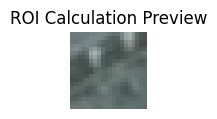

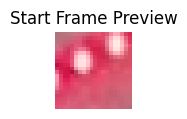

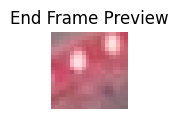

View: 0: Count: 1941, from(00121.jpg) to(02062.jpg)


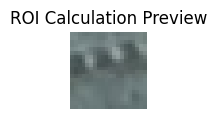

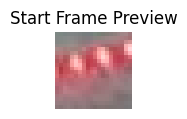

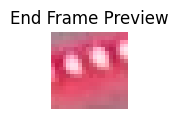

View: 1: Count: 1942, from(00127.jpg) to(02069.jpg)


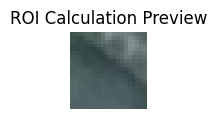

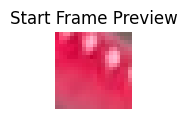

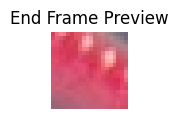

View: 2: Count: 1941, from(00062.jpg) to(02003.jpg)


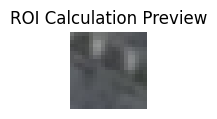

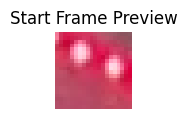

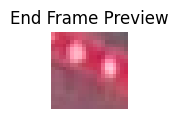

View: 3: Count: 1941, from(00034.jpg) to(01975.jpg)


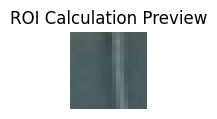

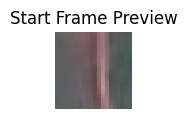

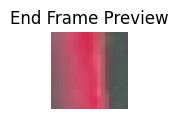

View: 4: Count: 1942, from(00040.jpg) to(01982.jpg)


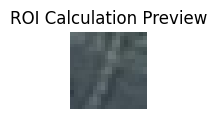

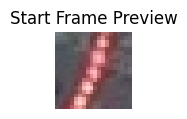

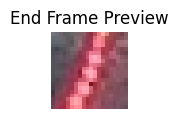

View: 5: Count: 1940, from(00053.jpg) to(01993.jpg)


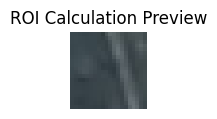

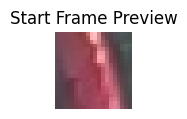

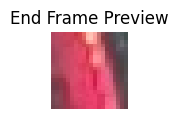

View: 6: Count: 1940, from(00083.jpg) to(02023.jpg)


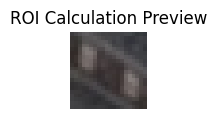

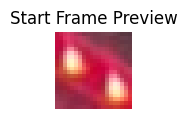

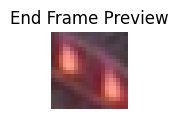

View: 7: Count: 1941, from(00125.jpg) to(02066.jpg)


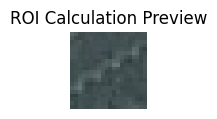

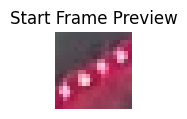

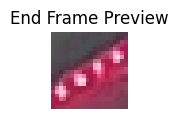

View: 8: Count: 1940, from(00049.jpg) to(01989.jpg)


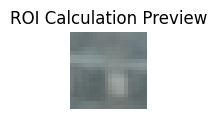

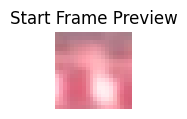

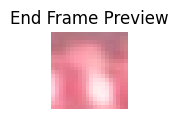

View: 9: Count: 1939, from(00067.jpg) to(02006.jpg)


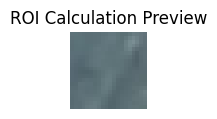

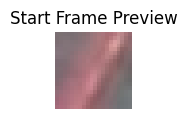

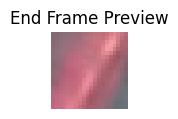

View: 10: Count: 1939, from(00066.jpg) to(02005.jpg)


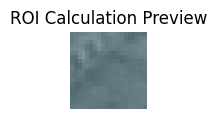

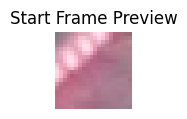

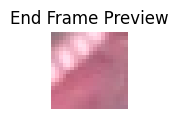

View: 11: Count: 1939, from(00067.jpg) to(02006.jpg)


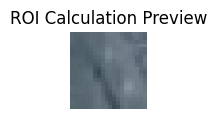

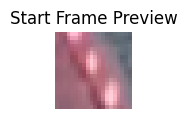

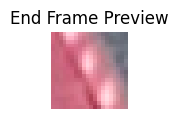

View: 12: Count: 1939, from(00066.jpg) to(02005.jpg)


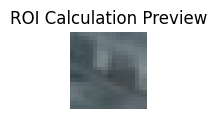

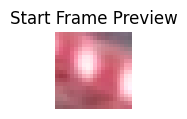

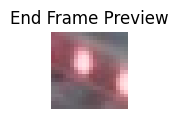

View: 13: Count: 1938, from(00067.jpg) to(02005.jpg)


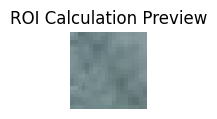

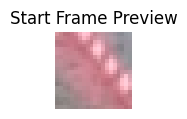

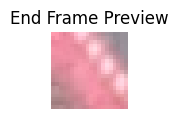

View: 14: Count: 1939, from(00066.jpg) to(02005.jpg)


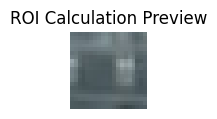

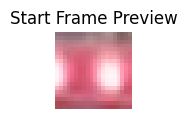

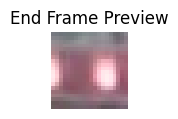

View: 15: Count: 1938, from(00067.jpg) to(02005.jpg)


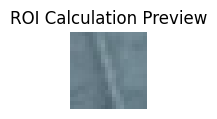

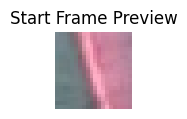

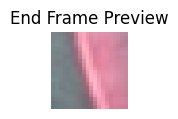

View: 16: Count: 1939, from(00067.jpg) to(02006.jpg)


In [26]:
crop_frame_locs = []
frame_count = 900 # init approximate frame count
for i, view_folder in enumerate(stage_2_rgb_sequence_by_view_folders):
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(view_folder, ext)))
    images = sorted(images)
    
    start, end = detect_flash(images, led_roi[i], 10, 10000, frame_count - 90)
    frame_count = end - start
    crop_frame_locs.append([start, end])
    if (start != -1 and end != -1):
        print(f"View: {i}: Count: {end - start}, from({os.path.basename(images[start])}) to({os.path.basename(images[end])})")
    elif(start == -1):
        frame_count = 900
        print(f"View: {i}, Start: Not Found, End: Not Found")
    elif(end == -1):
        frame_count = 900
        print(f"View: {i}, Start: {os.path.basename(images[start])}, End: Not Found")

### Crop RGB Sequence by Reported Crop Location

In [27]:
for i, view_folder in enumerate(stage_2_rgb_sequence_by_view_folders):
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(view_folder, ext)))
    images = sorted(images)

    start, end = crop_frame_locs[i]

    for j in range(0, start):
        os.remove(images[j])

    for k in range(end + 1, len(images)):
        os.remove(images[k])

    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(view_folder, ext)))
    images = sorted(images)
    # raname images after removing the first frames name format: 00000.jpg, 00001.jpg, ...
    for j, image in enumerate(images):
        new_name = f"{j:05d}.jpg"
        new_path = os.path.join(view_folder, new_name)
        os.rename(image, new_path)

    print(f"View: {i}, Updated frames: {len(images)}")


View: 0, Updated frames: 1942
View: 1, Updated frames: 1943
View: 2, Updated frames: 1942
View: 3, Updated frames: 1942
View: 4, Updated frames: 1943
View: 5, Updated frames: 1941
View: 6, Updated frames: 1941
View: 7, Updated frames: 1942
View: 8, Updated frames: 1941
View: 9, Updated frames: 1940
View: 10, Updated frames: 1940
View: 11, Updated frames: 1940
View: 12, Updated frames: 1940
View: 13, Updated frames: 1939
View: 14, Updated frames: 1940
View: 15, Updated frames: 1939
View: 16, Updated frames: 1940


### Extract Camera Pose Frame

In [ ]:
# generate training data - first frame

frames_by_views = []
for i, view_folder in enumerate(stage_2_rgb_sequence_by_view_folders):
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(view_folder, ext)))

    images = sorted(images)
    
    frames_by_views.append(images)

first_frame_folder = os.path.join(final_training_dataset, "frame_0")
for view_number in range(len(frames_by_views)):
    move_to_folder(frames_by_views[view_number][0], first_frame_folder, f"{view_number:05d}")

### Background Removal

In [29]:
# Remove background

model = torch.hub.load("PeterL1n/RobustVideoMatting", "mobilenetv3").cuda()
convert_video = torch.hub.load("PeterL1n/RobustVideoMatting", "converter")

temp_folder = rf"{output_dataset}\temp"
if not os.path.exists(temp_folder):
    os.makedirs(temp_folder)

frames_nobg_by_view_folders = []

for i, view_folder in enumerate(stage_2_rgb_sequence_by_view_folders):
    temp_sequence_folder = os.path.join(temp_folder, f"view_{i:02d}")
    convert_video(
        model,                           # The loaded model, can be on any device (cpu or cuda).
        input_source=view_folder,        # A video file or an image sequence directory.
        downsample_ratio=None,           # [Optional] If None, make downsampled max size be 512px.
        output_type='png_sequence',             # Choose "video" or "png_sequence"
        output_composition=temp_sequence_folder,    # File path if video; directory path if png sequence.
        #output_alpha=f"{output}/pha.mp4",          # [Optional] Output the raw alpha prediction.
        #output_foreground=f"{output}/fgr.mp4",     # [Optional] Output the raw foreground prediction.
        #output_video_mbps=4,             # Output video mbps. Not needed for png sequence.
        seq_chunk=15,                    # Process n frames at once for better parallelism.
        num_workers=5,                   # Only for image sequence input. Reader threads.
        progress=True                    # Print conversion progress.
    )
    frames_nobg_by_view_folders.append(temp_sequence_folder)

Using cache found in C:\Users\otuga/.cache\torch\hub\PeterL1n_RobustVideoMatting_master
Using cache found in C:\Users\otuga/.cache\torch\hub\PeterL1n_RobustVideoMatting_master
100%|██████████| 1939/1939 [03:43<00:00,  8.67it/s]


In [ ]:
temp_folder = rf"{output_dataset}\temp"

frames_nobg_by_view_folders = [d for d in os.listdir(temp_folder) if os.path.isdir(os.path.join(temp_folder, d))]
frames_nobg_by_view_folders = sorted(frames_nobg_by_view_folders)
frames_nobg_by_view_folders = [os.path.join(temp_folder, folder) for folder in frames_nobg_by_view_folders]

frames_nobg_by_views = []

for i, folder in enumerate(frames_nobg_by_view_folders):
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(folder, ext)))

    images = sorted(images)
    frames_nobg_by_views.append(images)

for i, view in enumerate(frames_nobg_by_views):
    print(f"View: {i}, Number of frames: {len(view)}")


View: 0, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_00, Number of frames: 1941
View: 1, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_01, Number of frames: 1942
View: 2, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_02, Number of frames: 1941
View: 3, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_03, Number of frames: 1941
View: 4, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_04, Number of frames: 1942
View: 5, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_05, Number of frames: 1940
View: 6, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_06, Number of frames: 1940
View: 7, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_07, Number of frames: 1941
View: 8, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_08, Number of frames: 1940
View: 9, Path: C:\repos\_DATASETS_\4dgs-250729\gs-take-00\out\temp\view_09, Number of frames: 1939
View: 10, 

### Report Data Structure for Stage 3

In [ ]:
min_num_of_frames = min(len(view) for view in frames_nobg_by_views)

for i, frames_by_view in enumerate(frames_nobg_by_views):
    for j, frame in enumerate(frames_by_view):
        if j < min_num_of_frames:
            dst = os.path.join(final_training_dataset, f"frame_{j:05d}")
            move_to_folder(frame, dst, f"{i:05d}")

In [ ]:
stage_3_frame_folders = [d for d in os.listdir(final_training_dataset) if os.path.isdir(os.path.join(final_training_dataset, d))]
stage_3_frame_folders = sorted(stage_3_frame_folders)
stage_3_frame_folders = [os.path.join(final_training_dataset, folder) for folder in stage_3_frame_folders]

for i, folder in enumerate(stage_3_frame_folders):
    images = []
    for ext in image_extensions:
        images.extend(glob.glob(os.path.join(folder, ext)))

    images = sorted(images)
    print(f"Frame: {folder}, Views: {len(images)}")


In [ ]:
if (rs_first_align(rs_exe, images_path, export_path, xml_path)):
    print(f"First frame {first_frame.name} aligned successfully.")
    xmp_files = list(images_path.glob("*.xmp"))
    if not xmp_files:
        print(f"No XMP files found in {images_path}, skipping subsequent frames alignment.")
        exit(1)

    for xmp_file in xmp_files:
        for frame_folder in frame_folders[1:]:
            shutil.copy2(xmp_file, frame_folder/"images")
            print(f"Copied XMP file {xmp_file.name} to {frame_folder/'images'}")
else:
    print(f"Failed to align first frame {first_frame.name}. Exiting.")
    exit(1)

# Process subsequent frames
for frame_folder in frame_folders[1:]:
    images_path = frame_folder/"images"
    export_path = export_path_base/frame_folder.name
    export_path.mkdir(parents=True, exist_ok=True)

    if not images_path.exists():
        print(f"Warning: Images folder not found in {frame_folder.name}, skipping...")
        continue
    
    try:
        if rs_align_with_xmp(rs_exe, images_path, export_path, xml_path):
            print(f"Frame {frame_folder.name} aligned successfully.")
        else:
            print(f"Failed to align frame {frame_folder.name}.")
    except Exception as e:
        print(f"Error processing frame {frame_folder.name}: {e}")
        continue
    

## Stage 3

In [ ]:
first_frame = stage_3_frame_folders[0]

convert_jpg_to_png(first_frame)

In [11]:
convert_video(
    model,                           # The loaded model, can be on any device (cpu or cuda).
    input_source=r"C:\repos\_DATASETS_\4dgs-250729-2\output_dataset\Test\soar_view_7",        # A video file or an image sequence directory.
    downsample_ratio=None,           # [Optional] If None, make downsampled max size be 512px.
    output_type='png_sequence',             # Choose "video" or "png_sequence"
    output_composition=r"C:\repos\_DATASETS_\4dgs-250729-2\output_dataset\Test\view16nobgwrot",    # File path if video; directory path if png sequence.
    #output_alpha=f"{output}/pha.mp4",          # [Optional] Output the raw alpha prediction.
    #output_foreground=f"{output}/fgr.mp4",     # [Optional] Output the raw foreground prediction.
    #output_video_mbps=4,             # Output video mbps. Not needed for png sequence.
    seq_chunk=15,                    # Process n frames at once for better parallelism.
    num_workers=5,                   # Only for image sequence input. Reader threads.
    progress=True                    # Print conversion progress.
)

100%|██████████| 1939/1939 [03:55<00:00,  8.24it/s]


In [88]:

def extract_brightness_contrast(reference_image_path):
    image = cv2.imread(reference_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Convert to grayscale for global statistics
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate brightness (mean intensity)
    target_brightness = np.mean(gray)
    
    # Calculate contrast (standard deviation)
    target_contrast = np.std(gray)
    
    # Calculate per-channel statistics for color correction
    channel_means = [np.mean(image_rgb[:, :, i]) for i in range(3)]
    channel_stds = [np.std(image_rgb[:, :, i]) for i in range(3)]
    
    brightness_contrast_data = {
        'target_brightness': target_brightness,
        'target_contrast': target_contrast,
        'channel_means': channel_means,  # [R, G, B]
        'channel_stds': channel_stds,    # [R, G, B]
        'reference_image_path': reference_image_path
    }
    
    print(f"Reference image: {reference_image_path}")
    print(f"Target brightness: {target_brightness:.2f}")
    print(f"Target contrast: {target_contrast:.2f}")
    print(f"Channel means (R,G,B): [{channel_means[0]:.2f}, {channel_means[1]:.2f}, {channel_means[2]:.2f}]")
    print(f"Channel stds (R,G,B): [{channel_stds[0]:.2f}, {channel_stds[1]:.2f}, {channel_stds[2]:.2f}]")
    
    return brightness_contrast_data

def apply_brightness_contrast(input_image_path, brightness_contrast_data):
    # Load the input image
    image = cv2.imread(input_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Get target values
    target_brightness = brightness_contrast_data['target_brightness']
    target_contrast = brightness_contrast_data['target_contrast']
    target_means = brightness_contrast_data['channel_means']
    target_stds = brightness_contrast_data['channel_stds']
    
    # Calculate current image statistics
    current_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    current_brightness = np.mean(current_gray)
    current_contrast = np.std(current_gray)
    
    current_means = [np.mean(image_rgb[:, :, i]) for i in range(3)]
    current_stds = [np.std(image_rgb[:, :, i]) for i in range(3)]
    
    # Create corrected image
    corrected_image = image_rgb.copy().astype(np.float32)
    
    # Apply correction to each channel
    for channel in range(3):
        if current_stds[channel] > 0:  # Avoid division by zero
            # Normalize current channel to have mean=0, std=1
            corrected_image[:, :, channel] = (corrected_image[:, :, channel] - current_means[channel]) / current_stds[channel]
            
            # Scale to target std and shift to target mean
            corrected_image[:, :, channel] = corrected_image[:, :, channel] * target_stds[channel] + target_means[channel]
    
    # Clip values to valid range [0, 255]
    corrected_image = np.clip(corrected_image, 0, 255).astype(np.uint8)
    
    # Convert back to BGR for saving
    corrected_bgr = cv2.cvtColor(corrected_image, cv2.COLOR_RGB2BGR)
    
    # Replace the original image
    cv2.imwrite(input_image_path, corrected_bgr)
    
    # Print statistics
    corrected_gray = cv2.cvtColor(corrected_bgr, cv2.COLOR_BGR2GRAY)
    final_brightness = np.mean(corrected_gray)
    final_contrast = np.std(corrected_gray)
    
    print(f"\nProcessed: {input_image_path}")
    print(f"Brightness: {current_brightness:.2f} -> {final_brightness:.2f} (Target: {target_brightness:.2f})")
    print(f"Contrast: {current_contrast:.2f} -> {final_contrast:.2f} (Target: {target_contrast:.2f})")
    print(f"✓ Original image replaced with corrected version")

# Example usage:

# Step 1: Extract brightness/contrast data from reference image
reference_path = r"C:\Users\otuga\Desktop\test_frames\1.jpg"
bc_data = extract_brightness_contrast(reference_path)

print("\n" + "="*50)

image_extensions = ['*.jpg', '*.jpeg', '*.png']

image_paths = []
for ext in image_extensions:
    image_paths.extend(glob.glob(os.path.join(r"C:\Users\otuga\Desktop\test_frames", ext)))

for img_path in image_paths:
    apply_brightness_contrast(img_path, bc_data)
    print("-" * 30)

print("\n✓ All images have been processed and replaced with corrected versions!")

Reference image: C:\Users\otuga\Desktop\test_frames\1.jpg
Target brightness: 117.96
Target contrast: 51.23
Channel means (R,G,B): [112.06, 123.87, 103.05]
Channel stds (R,G,B): [62.26, 50.85, 49.91]


Processed: C:\Users\otuga\Desktop\test_frames\1.jpg
Brightness: 117.96 -> 117.94 (Target: 117.96)
Contrast: 51.23 -> 51.26 (Target: 51.23)
✓ Original image replaced with corrected version
------------------------------

Processed: C:\Users\otuga\Desktop\test_frames\10.jpg
Brightness: 135.69 -> 117.48 (Target: 117.96)
Contrast: 59.79 -> 50.30 (Target: 51.23)
✓ Original image replaced with corrected version
------------------------------

Processed: C:\Users\otuga\Desktop\test_frames\11.jpg
Brightness: 121.54 -> 117.65 (Target: 117.96)
Contrast: 52.99 -> 51.49 (Target: 51.23)
✓ Original image replaced with corrected version
------------------------------

Processed: C:\Users\otuga\Desktop\test_frames\12.jpg
Brightness: 127.40 -> 117.47 (Target: 117.96)
Contrast: 56.77 -> 50.33 (Target: 51.2

Using cache found in C:\Users\jeffr/.cache\torch\hub\PeterL1n_RobustVideoMatting_master
Using cache found in C:\Users\jeffr/.cache\torch\hub\PeterL1n_RobustVideoMatting_master
c:\Users\jeffr\.conda\envs\rvm\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 1923/1923 [02:18<00:00, 13.91it/s]
